# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('data/TRAIN.csv')
test = pd.read_csv('data/TEST.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
# bins = [-np.inf, 30, 50, np.inf]

# train['age'] = pd.cut(train['age'], bins, labels=False)
# test['age'] = pd.cut(test['age'], bins, labels=False)

In [4]:
# bins = [-np.inf, 30, 50, 60, 70, 80, 90, 100, np.inf]

# train['weight'] = pd.cut(train['weight'], bins, labels=False)
# test['weight'] = pd.cut(test['weight'], bins, labels=False)

In [5]:
# bins = [-np.inf, 150, 160, 170, 185, np.inf]

# train['height'] = pd.cut(train['height'], bins, labels=False)
# test['height'] = pd.cut(test['height'], bins, labels=False)

In [6]:
# fix values to limits

test['lbp'] = np.where(test['lbp'] > 170, test['lbp'].median(), test['lbp'])
test['lbp'] = np.where(test['lbp'] < 40, test['lbp'].median(), test['lbp'])

train['lbp'] = np.where(train['lbp'] > 170, train['lbp'].median(), train['lbp'])
train['lbp'] = np.where(train['lbp'] < 40, train['lbp'].median(), train['lbp'])

test['ubp'] = np.where(test['ubp'] > 200, test['ubp'].median(), test['ubp'])
test['ubp'] = np.where(test['ubp'] < 50, test['ubp'].median(), test['ubp'])

train['ubp'] = np.where(train['ubp'] > 200,  train['ubp'].median(), train['ubp'])
train['ubp'] = np.where(train['ubp'] < 50,  train['ubp'].median(), train['ubp'])

In [7]:
train['lbp'] = train['lbp'].astype(int)
test['lbp'] = test['lbp'].astype(int)

train['ubp'] = train['ubp'].astype(int)
test['ubp'] = test['ubp'].astype(int)

In [8]:
train['age'] = train['age'].astype(int)
test['age'] = test['age'].astype(int)

train['age'] = train['age'].astype(int)
test['age'] = test['age'].astype(int)

In [9]:
train['weight'] = train['weight'].astype(int)
test['weight'] = test['weight'].astype(int)

train['weight'] = train['weight'].astype(int)
test['weight'] = test['weight'].astype(int)

In [10]:
# bins = [-np.inf, 90, 100, 110, 120, 130, 140, 150, 180, np.inf]
# label = 'ubp'

# train[label] = pd.cut(train[label], bins, labels=False)
# test[label] = pd.cut(test[label], bins, labels=False)

In [11]:
# bins = [-np.inf, 70, 80, 90, np.inf]

# train['lbp'] = pd.cut(train['lbp'], bins, labels=False)
# test['lbp'] = pd.cut(test['lbp'], bins, labels=False)

In [12]:
print('train, test, sample_submission shapes')
print(train.shape, test.shape, sample_submission.shape)
train.head(5)

train, test, sample_submission shapes
(70000, 13) (30000, 12) (30000, 2)


,id,age,weight,height,sex,stress,doctor,sport,pernicious_1,pernicious_2,ubp,lbp,insomnia
0,0,50,62,168,2,1,1,1,0,0,110,80,0
1,1,55,85,156,1,3,1,1,0,0,140,90,1
2,2,51,64,165,1,3,1,0,0,0,130,70,1
3,3,48,82,169,2,1,1,1,0,0,150,100,1
4,4,47,56,156,1,1,1,0,0,0,100,60,0


# Data analysis

In [13]:
feat_research = pd.DataFrame(train.isna().sum() / train.shape[0], columns=['train_null_share'])
feat_research['test_null_share'] = test.isna().sum() / test.shape[0]
feat_research['train_dtypes'] = train.dtypes
feat_research['train_mean'] = train.mean()
feat_research['test_mean'] = test.mean()

feat_research

,train_null_share,test_null_share,train_dtypes,train_mean,test_mean
id,0.0,0.000000,int64,49972.419900,50062.686900
age,0.0,0.000000,int64,52.803257,52.766267
weight,0.0,0.000000,int64,74.204329,74.119300
height,0.0,0.000000,int64,164.359229,164.322267
sex,0.0,0.000000,int64,1.349571,1.353733
stress,0.0,0.000000,int64,1.366871,1.368033
doctor,0.0,0.000000,int64,1.226457,1.222700
sport,0.0,0.096567,int64,0.803729,0.805926
pernicious_1,0.0,0.101000,int64,0.088129,0.087838
pernicious_2,0.0,0.101033,int64,0.053771,0.054470


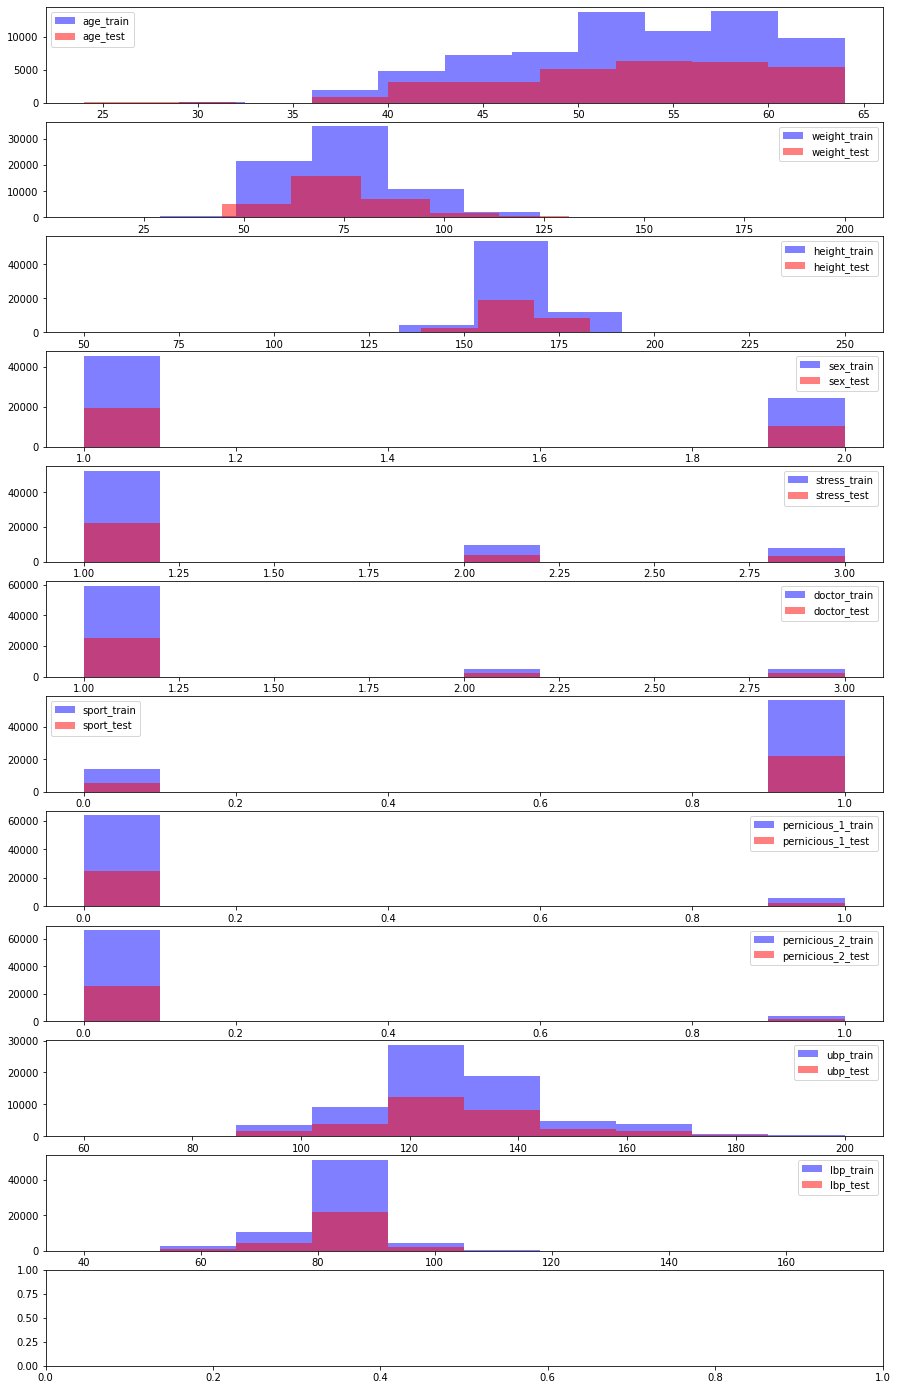

In [14]:
# data distribution 

fig, ax = plt.subplots(len(train.columns)-1, 1)
fig.set_figheight(25)
fig.set_figwidth(15)


for i in range(1, len(test.columns)):
    feat = train.columns[i]
    ax[i-1].hist(train[feat], label=feat+'_train', alpha=0.5, color='blue')
    ax[i-1].hist(test[feat], label=feat+'_test', alpha=0.5, color='red')
    ax[i-1].legend()

plt.show()

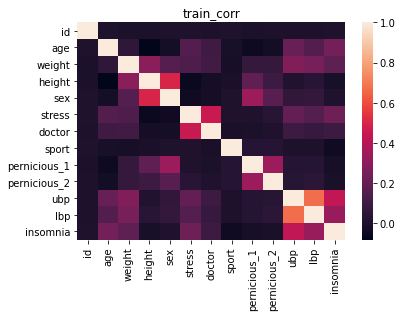

In [15]:
# train correlation matrix

sns.heatmap(train.corr(), annot=False)
plt.title('train_corr')
plt.show()

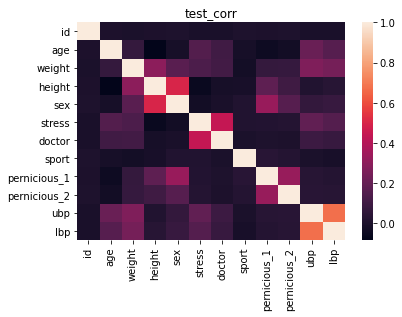

In [16]:
# test correlation matrix

sns.heatmap(test.corr())
plt.title('test_corr')
plt.show()

# Data engineering

Process nulls

In [17]:
# fix nulls

test['sport'] = test['sport'].median()

In [18]:
test['pernicious_1'] = test['pernicious_1'].fillna(0)
test['pernicious_2'] = test['pernicious_2'].fillna(0)
test['pernicious'] = np.where(test['pernicious_1'] + test['pernicious_2'] > 0, 1, 0 )

train['pernicious_1'] = train['pernicious_1'].fillna(0)
train['pernicious_2'] = train['pernicious_2'].fillna(0)
train['pernicious'] = np.where(train['pernicious_1'] + train['pernicious_2'] > 0, 1, 0 )

In [19]:
train['ubp_danger'] = np.where(train['ubp'] > 160, 1, 0 )
test['ubp_danger'] = np.where(test['ubp'] > 160, 1, 0 )

In [22]:
# one-hot-encoding categorical features

stress_train_ohe = pd.get_dummies(train['stress'], prefix='stress').drop(columns='stress_3')
stress_test_ohe = pd.get_dummies(test['stress'], prefix='stress').drop(columns='stress_3')

train = train.drop(columns='stress')
test = test.drop(columns='stress')

train = train.join(stress_train_ohe)
test = test.join(stress_test_ohe)

Drop less correlated with target

In [23]:
to_drop = ['id', 'pernicious_1', 'pernicious_2', 'sex']
train = train.drop(columns=to_drop)
test = test.drop(columns=to_drop)

# Training pipeline

In [24]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# CatBoost
from catboost import CatBoostClassifier

In [25]:
# train-test split

X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='insomnia'),
                                                  train['insomnia'],
                                                  test_size=0.3,
                                                  random_state=42)

In [26]:
pipe = Pipeline([('poly', PolynomialFeatures(1)),
                 ('scaler', StandardScaler()),
                 ('cbr', CatBoostClassifier(
                     silent=True,
                     random_seed=42,
                     min_data_in_leaf=3,
                     loss_function='Logloss')
                 ),
                ])

cbr_par = {
    'cbr__iterations': [20, 30, 50],
    'cbr__depth': [3, 4],
}
cbr = CatBoostClassifier(silent=True)
cbr_gscv = GridSearchCV(pipe, cbr_par)
cbr_gscv.fit(X_train, y_train)
cbr_best = cbr_gscv.best_estimator_

print('best params: {}'.format(cbr_gscv.best_params_))
print('logloss on best model: {}'.format(log_loss(y_val, cbr_best.predict_proba(X_val))))

best params: {'cbr__depth': 4, 'cbr__iterations': 50}
logloss on best model: 0.5379377728764195


In [27]:
# best:
# 0.5377995733309379
# 0.5376065542377049

In [28]:
# feature importances for best model

print(X_train.columns)
cbr_best.steps[2][1].feature_importances_

Index(['age', 'weight', 'height', 'doctor', 'sport', 'ubp', 'lbp',
       'pernicious', 'ubp_danger', 'stress_1', 'stress_2'],
      dtype='object')


array([ 0.        , 23.62228229,  5.59266629,  3.06421106,  2.51609279,
        1.45585783, 36.23595956,  6.83901213,  1.58187785,  1.19810733,
       13.60088314,  4.29304975])

### Making a submission 

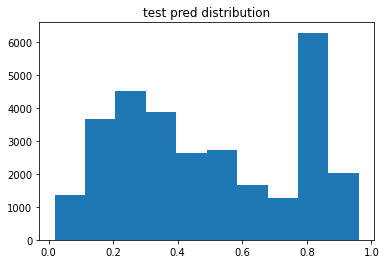

In [29]:
test_pred = cbr_best.predict_proba(test)[:, 1]

plt.hist(test_pred)
plt.title('test pred distribution')
plt.show()

In [30]:
test_submission = pd.DataFrame(sample_submission['id'])
test_submission['insomnia'] = test_pred
test_submission.head()

,id,insomnia
0,5,0.522588
1,6,0.554629
2,7,0.330382
3,10,0.491208
4,11,0.211418


In [31]:
# check shapes

sample_submission.shape == test_submission.shape

True

In [32]:
test_submission = test_submission.to_csv('out/catboost.csv', index=False)